In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import io

Using TensorFlow backend.


In [3]:
from google.colab import files
uploaded = files.upload()

Saving BTC_Book_0.zip to BTC_Book_0 (5).zip
Saving BTC_Book_1.zip to BTC_Book_1 (1).zip


In [0]:
raw = pd.read_csv(io.BytesIO(uploaded['BTC_Book_0.zip']), compression = 'zip', parse_dates = True, index_col = 0)
raw = raw.append(pd.read_csv(io.BytesIO(uploaded['BTC_Book_1.zip']), compression = 'zip', parse_dates = True, index_col = 0))

#reorder data sets
prices = raw[raw.columns[1::3]]
p_cols = list(np.flip(prices.columns.values[:50])) + list(prices.columns.values[50:])
prices = prices[p_cols]

sizes = raw[raw.columns[2::3]]
s_cols = list(np.flip(sizes.columns.values[:50])) + list(sizes.columns.values[50:])
sizes = sizes[s_cols]

trades = raw[raw.columns[3::3]]
t_cols = list(np.flip(trades.columns.values[:50])) + list(trades.columns.values[50:])
trades = trades[t_cols]

(99976, 25, 100)


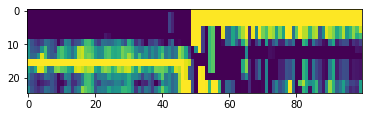

In [5]:
from sklearn.preprocessing import MinMaxScaler

def rolling_window(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

time_slices = rolling_window(prices.values, 25)
print(time_slices.shape)

new_slices = np.zeros(time_slices.shape)

time_scaler = MinMaxScaler(feature_range=(0,1))
for i in range(time_slices.shape[0]):
  img = time_slices[i]
  time_scaler.fit(img)
  img_tr = time_scaler.transform(img)
  new_slices[i,:,:] = img_tr.copy()


plt.imshow(new_slices[0])

(100000,)
(100000,)
(100000,)


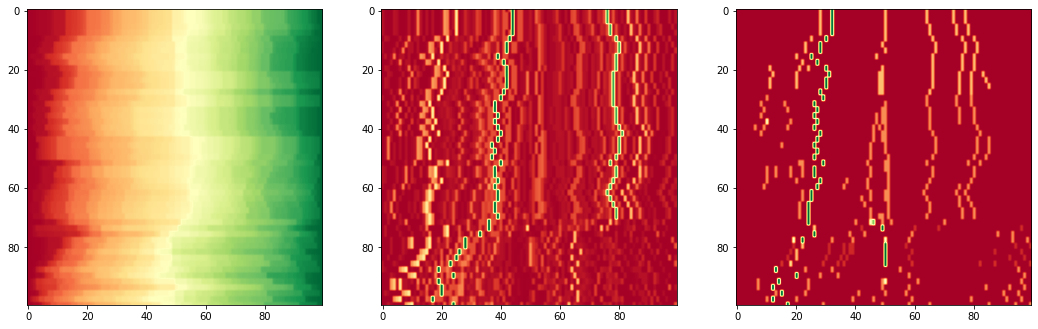

In [6]:
from sklearn.preprocessing import MinMaxScaler

#scale prices
p_scaler = MinMaxScaler(feature_range=(0,1))
p_scaler.fit(prices.T)
print(p_scaler.min_.shape)
price_tr = p_scaler.transform(prices.T).T

#scale sizes
s_scaler = MinMaxScaler(feature_range=(0,1))
s_scaler.fit(sizes.T)
print(s_scaler.min_.shape)
size_tr = s_scaler.transform(sizes.T).T

#scale trades
t_scaler = MinMaxScaler(feature_range=(0,1))
t_scaler.fit(trades.T)
print(t_scaler.min_.shape)
trade_tr = t_scaler.transform(trades.T).T


#plot example
start = 0
window = 100
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 6))
ax[0].imshow(price_tr[start:start + window], cmap = 'RdYlGn')
ax[1].imshow(size_tr[start:start + window], cmap = 'RdYlGn')
ax[2].imshow(trade_tr[start:start + window], cmap = 'RdYlGn')

In [8]:
#setting up X for training
def rolling_window(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


window = 25
price_roll = rolling_window(price_tr, window)
size_roll = rolling_window(size_tr, window)
trade_roll = rolling_window(trade_tr, window)

total = np.stack((price_roll, size_roll, trade_roll, new_slices),axis = -1)
total.shape

(99976, 25, 100, 4)

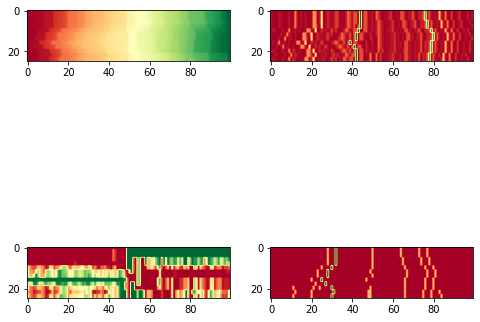

In [9]:
start = 0
window = 100
sample = 0
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 8))
ax[0][0].imshow(total[sample][:,:,0], cmap = 'RdYlGn')
ax[0][1].imshow(total[sample][:,:,1], cmap = 'RdYlGn')
ax[1][1].imshow(total[sample][:,:,2], cmap = 'RdYlGn')
ax[1][0].imshow(total[sample][:,:,3], cmap = 'RdYlGn')

In [10]:
#Setting up Targets for training
from sklearn.preprocessing import OneHotEncoder

mid_price = pd.DataFrame((prices['Bid_1_Price'] + prices['Ask_1_Price'])/2 ,columns = ['mid_price'])
mid_price['target'] = mid_price['mid_price'].diff(1).shift(-1)
sd = mid_price['target'].std()

def return_cat(x, stdev):
    if x > (0 + stdev):
        return 1
    if x < (0 - stdev):
        return -1
    else:
        return 0

mid_price['target_cat'] = mid_price['target'].apply(return_cat, args = (sd,)) #not NAN for indices 0 - 49998 - last is nan
mid_price = mid_price.dropna()
    
encoder = OneHotEncoder()
encoder.fit(mid_price['target_cat'].values.reshape(-1,1))
target_one_hot = encoder.transform(mid_price['target_cat'].values.reshape(-1,1)).toarray()
print(target_one_hot.shape)
target_one_hot

(99999, 3)


array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [14]:
#Setting Train Sets
X = total[:len(total)-1] #remove last since no prediction
print(X.shape)

Y = target_one_hot[24:] ##window-1## #no predictions for indicies 0 -> 98 (99 steps), index 99 has first 1 step ahead
print(Y.shape)

X_train = X[:80000]
Y_train = Y[:80000]

X_test = X[80000:]
Y_test = Y[80000:]

(99975, 25, 100, 4)
(99975, 3)


In [15]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
rus.fit_resample(X_train[:,:,0,0], Y_train)

Y_res = Y_train[rus.sample_indices_]
X_res = X_train[rus.sample_indices_]

print(Y_res.shape)
print(X_res.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(8190, 3)
(8190, 25, 100, 4)


In [22]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

def build_cnn_model(activation, input_shape):
    model = Sequential()
    
    # 2 Convolution layer with Max polling
    model.add(Conv2D(32, 5, activation = activation, padding = 'same', input_shape = input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 5, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(MaxPooling2D())  
    model.add(Flatten())
    
    # 3 Full connected layer
    model.add(Dense(128, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(54, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(3, activation = 'softmax')) # 3 classes
    
    # summarize the model
    print(model.summary())
    return model

def compile_and_fit_model(model, X_train, y_train, X_test, y_test, batch_size, n_epochs):

    # compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy'])
#         loss='sparse_categorical_crossentropy',
#         metrics=['sparse_categorical_accuracy'])
    
    # define callbacks
    callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_categorical_accuracy', save_best_only=True)]
    
    # fit the model
    history = model.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))
    
    return model, history

# shape of the input images
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# create cnn model
cnn_model = build_cnn_model("relu", input_shape)
# train cnn model
trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, X_res, Y_res, X_test, Y_test, 100, 10)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 25, 100, 32)       3232      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 50, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 50, 64)        51264     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 25, 64)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9600)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               1228928   
_________________________________________________________________
dense_14 (Dense)             (None, 54)               

[[ 2483.   123.   124.]
 [16648. 46486. 11362.]
 [  387.   172.  2215.]]


Text(51.0, 0.5, 'True Label')

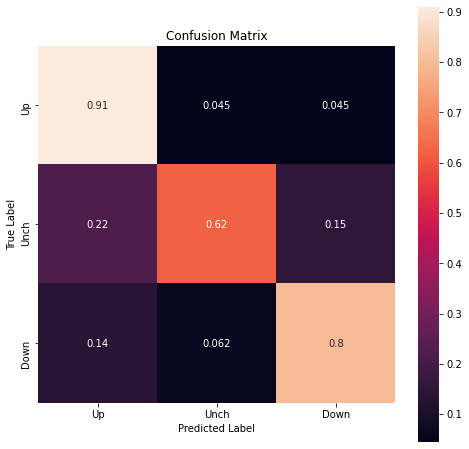

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(Y_train,1), np.argmax(trained_cnn_model.predict(X_train),1))
cm = cm.astype(float)

print(cm)

cm[0,:] = np.true_divide(cm[0,:], cm[0,:].sum())
cm[1,:] = np.true_divide(cm[1,:], cm[1,:].sum())
cm[2,:] = np.true_divide(cm[2,:], cm[2,:].sum())


import seaborn as sns

fig, axs = plt.subplots(1, figsize = (8,8))
axs = sns.heatmap(cm, xticklabels=['Up','Unch', 'Down'], 
                  yticklabels=['Up','Unch', 'Down'], annot = True,square=True)
axs.set_title("Confusion Matrix")
axs.set_xlabel('Predicted Label')
axs.set_ylabel('True Label')